In [1]:
import sys
import os
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sn
import torch.optim as optim
from PIL import Image
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
sys.path.insert(1, os.path.join(sys.path[0], '../'))
from pipeline.utils import list_files # noqa
from pipeline.dataset_constructor import return_data_loaders, time_it # noqa

In [3]:
class ETOracle:
    def __init__(self, window_size, stride):
        self.window_size = window_size
        self.stride = stride
    
    def generate_batch(self, batch):
        # Batch is a list of sequences of data
        # Each sequence has shape (seq_len, num_features)
        # We want to return a list of sequences of data.
        batch_size = len(batch)
        seq_len, num_features = batch[0].shape

        # Create empty tensors to hold the inputs and outputs
        x = torch.zeros(batch_size, self.window_size, num_features)
        y = torch.zeros(batch_size, seq_len - self.window_size, num_features)

        # Fill the tensors with the data by iterating over ech sequence in the batch
        for i, seq in enumerate(batch):
            # Split the sequence into overlapping windows
            for j in range(0, seq_len - self.window_size, self.stride):
                x[i, j, :] = seq[j:j+self.window_size, :]
                y[i, j, :] = seq[j+self.window_size:j+2*self.window_size, :]
        return x, y


class ETPatchEmbed(nn.Module):
    """
    Takes a 1D convolution of a patch of ET data to embed and returns the embedded data.
    The out.permute() is done to make the data compatible with the 1D convolution over batches.
    If OSIE is True, the oracle is used to generate a source and target sequence.
    """
    def __init__(self,
                 sample_height=300,
                 in_channels=3,
                 patch_size=15,
                 embed_dim=300,
                 kernel_size=15,
                 stride=15,
                 oracle=None,
                 OSIE=False):
        super().__init__()
        # These three lines are to make the patch embedding compatible with ETTransformer
        # -----
        sample_size = tuple((sample_height, in_channels))
        patch_size = tuple((patch_size, in_channels))
        num_patches = (sample_size[1] // patch_size[1] * sample_size[0] // patch_size[0])
        # -----
        self.sample_size = sample_size
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.norm = nn.BatchNorm1d(sample_height)
        self.projection = nn.Conv1d(in_channels=in_channels,
                                    out_channels=embed_dim,
                                    kernel_size=kernel_size,
                                    stride=stride)
        # self.OSIE = OSIE
        # self.oracle = oracle

    def forward(self, x):
        # if self.OSIE:
        #     x, y = self.oracle.generate_batch(x)
        #     x = self.norm(x)
        #     x = self.projection(x.permute(0, 2, 1)).transpose(1, 2)
        #     return x, y
        # else:
        x = self.norm(x)
        x = self.projection(x.permute(0, 2, 1)).transpose(1, 2)
        return x


class ImagePatchEmbed(nn.Module):
    """
    Takes a 2D convolution of a patch of an image data to embed in a lower dimensional space.
    """
    def __init__(self,
                 img_width=800,
                 img_height=600,
                 patch_size=25,
                 in_channels=3,
                 embed_dim=768):
        super().__init__()
        # self.img_size = img_size
        self.patch_size = patch_size
        # self.num_patches = (self.img_size // self.patch_size) ** 2
        self.projection = nn.Conv2d(in_channels=in_channels,
                                    out_channels=embed_dim,
                                    kernel_size=patch_size,
                                    stride=patch_size)
    def forward(self, x):
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)
        # print(x.shape)
        return x


class SemanticEmbedding(nn.Module):
    """
    Takes semantic tags per pixel of an image and embeds the information in the same space as ImagePatchEmbed.
    """
    def __init__(self,
                 img_width=800,
                 img_height=600,
                 patch_size=25,
                 in_cin_channelshans=12,
                 embed_dim=768):
        super().__init__()
        # self.img_size = img_size
        self.patch_size = patch_size
        # self.num_patches = (self.img_size // self.patch_size) ** 2
        self.projection = nn.Conv2d(in_channels=in_channels,
                                    out_channels=embed_dim,
                                    kernel_size=patch_size,
                                    stride=patch_size)
    def forward(self, x):
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)
        # print(x.shape)
        return x


In [4]:
class ETMLP(nn.Module):
    def __init__(self,
                 input_size=1200,
                 hidden_size=4096,
                 num_classes=335,
                 patch_size=100,
                 embed_dim=15,
                 OSIE=False):
        super().__init__()
        self.patch_embed = ETPatchEmbed()
        self.num_classes = num_classes
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(6000, 1024)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 2048)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(2048, 1024)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(1024, num_classes)
        self.relu4 = nn.ReLU()
        # self.OSIE = OSIE

    def forward(self, x):
        # if self.OSIE:
        #     et = et_embedding(et_data) # shape: (batch_size, num_patches, embed_dim
        #     imgs = visual_embedding(image_data) # shape: (batch_size, num_patches, embed_dim)
        #     semantics = semantic_embedding(semantic_data) # shape: (batch_size, num_patches, embed_dim)
        #     x = torch.cat((image_embed, semantic_embed, et_embed), dim=1) # shape: (batch_size, num_patches, embed_dim * 3)
        # else:
        x = self.patch_embed(x)
        x = self.flat(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.relu4(x)
        return x


class MLP(nn.Module):
    def __init__(self, in_features,
                 hidden_features=None,
                 out_features=None,
                 act_layer=nn.GELU, drop=0):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class ETAttention(nn.Module):
    def __init__(self,
                 dim,
                 num_heads=8,
                 qkv_bias=False,
                 qk_scale=None,
                 attn_drop=0.,
                 proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor can be set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3,
                                  self.num_heads, C //
                                  self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # torchscript cannot use tensor as tuple

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Block(nn.Module):
    def __init__(self,
                 dim,
                 num_heads,
                 mlp_ratio=4.,
                 qkv_bias=False,
                 qk_scale=None,
                 drop=0.,
                 attn_drop=0.,
                 act_layer=nn.GELU,
                 norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = ETAttention(dim,
                                num_heads=num_heads,
                                qkv_bias=qkv_bias,
                                qk_scale=qk_scale,
                                attn_drop=attn_drop,
                                proj_drop=drop)
        self.drop = nn.Dropout(attn_drop)
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim,
                       hidden_features=mlp_hidden_dim,
                       act_layer=act_layer,
                       drop=drop)

    def forward(self, x):
        x = x + self.drop(self.attn(self.norm1(x)))
        x = x + self.drop(self.mlp(self.norm2(x)))
        return x


class ETTransformer(nn.Module):
    def __init__(self,
                 sample_height=300,
                 sample_width=3,
                 patch_size=20,
                 in_channels=256,
                 num_classes=335,
                 embed_dim=20,
                 depth=6,
                 num_heads=10,
                 mlp_ratio=4.,
                 qkv_bias=True,
                 qk_scale=None,
                 drop_rate=0.1,
                 attn_drop_rate=0.1,
                 drop_path_rate=0.,
                 norm_layer=nn.LayerNorm):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim
        self.patch_embed = ETPatchEmbed(sample_height=sample_height,
                                        in_channels=sample_width,
                                        patch_size=patch_size,
                                        embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, embed_dim + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)
        self.blocks = nn.ModuleList([
            Block(dim=embed_dim,
                  num_heads=num_heads,
                  mlp_ratio=mlp_ratio,
                  qkv_bias=qkv_bias,
                  qk_scale=qk_scale,
                  drop=drop_rate,
                  attn_drop=attn_drop_rate,
                  norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        return x[:, 0]

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x


In [ ]:
# Example usage of a combined visual and semantic embedding  
image_data = ... # shape: (batch_size, 3, 224, 224)
semantic_data = ... # shape: (batch_size, 12, 224, 224)
et_data = ... # shape: (batch_size, 3, 300)

et_embedding = ETPatchEmbed()
visual_embedding = ImagePatchEmbed()  
semantic_embedding = SemanticEmbedding() 

et_embed = et_embedding(et_data) # shape: (batch_size, num_patches, embed_dim
image_embed = visual_embedding(image_data) # shape: (batch_size, num_patches, embed_dim)
semantic_embed = semantic_embedding(semantic_data) # shape: (batch_size, num_patches, embed_dim)
combined_embeds = torch.cat((image_embed, semantic_embed, et_embed), dim=1) # shape: (batch_size, num_patches, embed_dim * 3)

mbt_model = MBT(num_patches=num_patches, embed_dim=embed_dim * 3)
fused_embeds = mbt_model(final_embeds)  # shape: (batch_size, num_patches + 2, embed_dim * 3)

In [6]:
class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience.
    """
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

In [7]:
def gather_imgs_semantics():
    """
    Gather the data from the images and semantics folders, hardcoded for now.
    :return: The list of images and the list of semantics
    """
    imgs = os.path.abspath(os.path.join('..', 'pipeline', 'OSIE_imgs'))
    semantics = os.path.abspath(os.path.join('..', 'pipeline', 'OSIE_tags'))
    imgs_list = os.listdir(imgs)
    semantics_list = os.listdir(semantics)
    return imgs_list, semantics_list


def data_prep(data, OSIE=False, img_tag=None):
    """
    Prepare the data for the model by extracting the labels and inputs and converting them to tensors and moving them to the GPU.
    :param data: The data to prepare
    :param OSIE: Whether or not in OSIE paradigm.
    :param img_tag: The tag of the image to retrieve.
    :return: The inputs and labels
    """
    labels = data[:, 0, 0]  # Whole batch, first label, first timestamp
    labels = labels.type(torch.LongTensor) - 1
    inputs = data[:, 1:, 1:].float()  # Whole batch, exclude label, exclude timestamps
    inputs.requires_grad = True
    labels = labels.to(device)
    inputs = inputs.to(device)
    # Below prepares for the availabiltiy of the semantic and visual data alongside the ET data
    if OSIE:
        # TODO: Figure out how the imgs is signaled and retrieve the correct image and semantic batch-wise.
        # currently it retrieves only one image and semantic for the whole batch, which is not correct.
        # Furthermore, use the img_tag somehow to retrieve the correct image and semantic.
        imgs = np.asarray(Image.open(imgs_list[labels[1]])).to(device)
        semantics = np.asarray(sio.loadmat(semantics_list[label[1]])).to(device)
        return inputs, labels, imgs, semantics
    return inputs, labels


def train_pass(model, EPOCHS, loss_fn, OSIE=False):
    """
    Train the model for a given number of epochs, and return the final loss.
    :param model: The model to train.
    :param EPOCHS: The number of epochs to train for.
    :param loss_fn: The loss function to use.
    :param OSIE: Whether or not in OSIE paradigm.
    :return: The final loss.
    """
    running_loss = 0
    last_loss = 0
    for i, data in enumerate(train_dataloader):
        # Below prepares for the availabiltiy of the semantic and visual data alongside the ET data
        if OSIE:
            # TODO: Integrate several different modes for the model so it can use the imgs and semantics.
            inputs, labels, imgs, semantics = data_prep(data, OSIE=True)
            output = model(inputs, imgs, semantics)
        else:
            inputs, labels = data_prep(data)
            output = model(inputs)
            print(output.shape)
        loss = loss_fn(output, labels)
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        running_loss += loss.item()
        if i % 250 == 249:
            last_loss = running_loss / 249
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.
    return last_loss


def train_model(model, EPOCHS, loss_fn, batch_size=256, num_classes=335, OSIE=False):
    """
    Train the model for a given number of epochs, and return the final loss.
    :param model: The model to train.
    :param EPOCHS: The number of epochs to train for.
    :param loss_fn: The loss function to use.
    :param batch_size: The batch that is used.
    :param num_classes: The number of classes (is smaller in test set, but we don't want to limit the model's possible outputs).
    :param OSIE: Whether or not in the OSIE paradigm, changes the data and model.
    :return: The final loss.
    """
    loss_progress = []
    # Initialise lists to store the labels and outputs for each epoch, later used in eval
    eval_labels = np.zeros((EPOCHS, len(test_dataloader.dataset)))
    eval_outputs = np.zeros((EPOCHS, len(test_dataloader.dataset), num_classes))

    for epoch in range(EPOCHS):
        print('EPOCH {}:'.format(epoch + 1))
        model.train(True)
        avg_loss = train_pass(model, EPOCHS, loss_fn)
        model.train(False)

        running_vloss = 0.0
        for i, vdata in enumerate(test_dataloader):
            # Below prepares for the availabiltiy of the semantic and visual data alongside the ET data
            if OSIE:
                # TODO: See above todos, it currently has no way of working with the imgs and semantics.
                vinputs, vlabels, vimgs, vsemantics = data_prep(vdata, OSIE=True)
                voutput = model(vinputs, vimgs, vsemantics)
            else:
                vinputs, vlabels = data_prep(vdata)
                voutput = model(vinputs)
            start_index = i * batch_size
            end_index = start_index + batch_size
            # Below is done to account for the last batch, which may not be full
            if i == len(test_dataloader) - 1:
                num_samples_last_batch = len(vlabels)
                end_index = start_index + num_samples_last_batch
            # Store the labels and outputs for each epoch separatly so they can be used in eval
            eval_labels[epoch, start_index:end_index] = vlabels.detach().cpu().numpy()
            eval_outputs[epoch, start_index:end_index] = voutput.detach().cpu().numpy()
            vloss = loss_fn(voutput, vlabels)
            running_vloss += vloss
        avg_test_loss = running_vloss / (i + 1)
        loss_progress.append(avg_test_loss.cpu().detach())
        print('LOSS train {} valid {}'.format(avg_loss, avg_test_loss))
        
        early_stopping(avg_loss, avg_test_loss)
        if early_stopping.early_stop:
            print("We are at epoch:", i)
            break
    return eval_labels, eval_outputs, loss_progress

In [8]:
def topk_accuracy(eval_labels, eval_outputs, k=5, plot=False):
    """
    Calculate the top k accuracy for each epoc and return the list of accuracies.
    :param eval_labels: The labels for each epoch.
    :param eval_outputs: The outputs for each epoch.
    :param k: The k value to use.
    :param plot: Whether to plot the top k accuracy over epochs.
    :return: The list of top k accuracies.
    """
    topk_accuracy = []
    for i in range(len(eval_labels)):
        topk_classes = []
        for pred in eval_outputs[i]:
            classes = np.argsort(pred)[-k:]
            topk_classes.append(classes)
        correct = 0
        for j in range(len(eval_labels[i])):
            if eval_labels[i][j] in topk_classes[j]:
                correct += 1
        topk_accuracy.append(correct / len(eval_labels[i]))
    if plot:
        plt.plot(topk_accuracy)
        plt.title(f'Top {k} Accuracy over Epochs')
        plt.xlabel('Epoch Number')
        plt.ylabel('Accuracy')
        plt.savefig('0404-50.png')
        plt.show()
    return topk_accuracy


def eval_plots(eval_labels=None, eval_outputs=None, loss_progress=None, cf=False, loss_plot=False):
    """
    Take the labels and outputs of the model after training and evaluate the model.
    It first converts this into a single prediction label with softmax and one-hot encoding.
    Then, it plots the confusion matrix and the loss function progress over the epochs if enabled.
    :param eval_labels: The labels for each epoch.
    :param eval_outputs: The outputs for each epoch.
    :param loss_progress: The loss function progress over the epochs.
    :param cf: Whether to plot a confusion matrix.
    :param loss_plot: Whether to plot the loss function progress over the epochs.
    :return: None
    """
    if cf:
        labels = eval_labels[-1].astype(int)
        outputs = eval_outputs[-1]
        outputs = torch.softmax(torch.tensor(outputs), dim=1)
        outputs = torch.argmax(outputs, dim=1).numpy().astype(int)

        plt.figure(figsize=(20, 20))
        ax = plt.axes()
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        cf_matrix = confusion_matrix(labels, outputs)
        sn.heatmap(cf_matrix, annot=True, xticklabels=np.unique(outputs), yticklabels= np.unique(labels),
                fmt='g', cmap='Blues', linewidths=0.5, ax=ax)
        plt.savefig('T-50-CF.png')
        plt.show()
    if loss_plot:
        loss = np.array(loss_progress)
        plt.plot(loss)
        plt.xlabel('Epoch Number')
        plt.ylabel('Loss')
        plt.savefig('T-50-Loss.png')
        plt.show()

In [9]:
TorchFormer = torch.nn.Transformer(d_model=300, nhead=5, num_encoder_layers=6, num_decoder_layers=6,
                                   dim_feedforward=2048, dropout=0.1, custom_encoder=None,
                                   custom_decoder=None, layer_norm_eps=1e-05, batch_first=True,
                                   norm_first=False, device=None, dtype=None)

In [9]:
# model = ETTransformer()
model = ETMLP()

# imgs_list, semantics_list = gather_imgs_semantics()
early_stopping = EarlyStopping(tolerance=2, min_delta=0.1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=0.001, capturable=True, weight_decay=0.0001)
folder = os.path.abspath(os.path.join('..', 'DS10'))
files = list_files(folder)
train_dataloader, test_dataloader = return_data_loaders(files, 112, 14, batch_size=256) # 98 train, 28 test, 7 train rounds, 2 test rounds


EPOCHS = 20
eval_labels, eval_outputs, loss_progress = train_model(model, EPOCHS, loss_fn, batch_size=256)

Loading training data
Loading testing data
return_data_loaders took 9.798828 seconds
EPOCH 1:
torch.Size([256, 335])
torch.Size([256, 335])
torch.Size([256, 335])
torch.Size([256, 335])
torch.Size([256, 335])
torch.Size([256, 335])
torch.Size([256, 335])
torch.Size([256, 335])
torch.Size([256, 335])
torch.Size([256, 335])
torch.Size([256, 335])
torch.Size([256, 335])
torch.Size([256, 335])
torch.Size([256, 335])
torch.Size([256, 335])
torch.Size([256, 335])
torch.Size([256, 335])
torch.Size([256, 335])
torch.Size([256, 335])
torch.Size([256, 335])
torch.Size([256, 335])
torch.Size([256, 335])
torch.Size([256, 335])
torch.Size([256, 335])
torch.Size([256, 335])
torch.Size([256, 335])
torch.Size([256, 335])
torch.Size([256, 335])
torch.Size([256, 335])
torch.Size([256, 335])
torch.Size([256, 335])
torch.Size([256, 335])
torch.Size([256, 335])
torch.Size([256, 335])
torch.Size([256, 335])
torch.Size([256, 335])
torch.Size([256, 335])
torch.Size([256, 335])
torch.Size([256, 335])
torch.Siz

KeyboardInterrupt: 

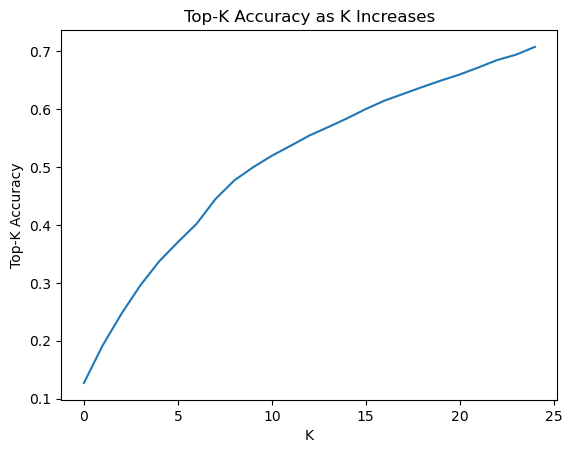

In [46]:
top5_acc = topk_accuracy(eval_labels, eval_outputs, k=5, plot=True)
print(max(top5_acc))

# topk = []
# for k in range(25):
#     print(f'Calculating top {k+1} accuracy...')
#     topk_acc = topk_accuracy(eval_labels, eval_outputs, k=k+1)
#     topk.append(max(topk_acc))
# plt.plot(topk)
# plt.title('Top-K Accuracy as K Increases')
# plt.xlabel('K')
# plt.ylabel('Top-K Accuracy')
# plt.savefig('Top K Function.png')
# plt.show()

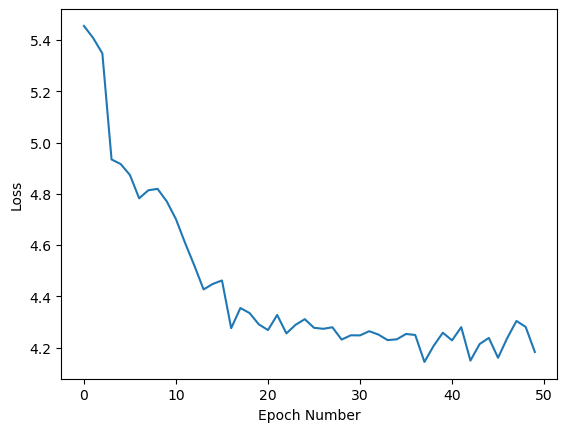

In [47]:
eval_plots(eval_labels=eval_labels, eval_outputs=eval_outputs, loss_progress=loss_progress, loss_plot=True, cf=False)